Using hourly interpolated averages

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import datetime
import xarray as xr
from salishsea_tools import tidetools, geo_tools, viz_tools
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
buoy = sio.loadmat('/ocean/rich/home/metro/ecbuoy/matlab/ECBUOY.mat')

In [3]:
buoy = buoy['ecbuoy']

In [4]:
buoy_dtype = buoy.dtype
buoydata = {n: buoy[n][0, 0] for n in buoy_dtype.names}

In [5]:
buoydata.keys()

dict_keys(['comment', 'lat', 'lon', 'tz', 'mtime', 'temp', 'specc', 'turb', 'salR', 'vel', 'airtemp', 'cwind', 'wspd', 'wdir', 'wu', 'wv', 'pH', 'O2', 'O2sat', 'dailyturb'])

In [6]:
temps = buoydata['temp'][:,0]
sals = buoydata['salR'][:,0]
mtimes = buoydata['mtime'][:,0]

In [7]:
mtimes.shape

(76535,)

In [8]:
base = datetime.datetime(2000, 1, 1)
py_buoy_times = np.array([base for i in range(76535)])
print(py_buoy_times.shape)
for n in range(76535):
    py_buoy_times[n] = ((datetime.datetime.fromordinal(int(mtimes[n])))
                       + datetime.timedelta(days=mtimes[n]%1)
                       - datetime.timedelta(days = 366))

(76535,)


In [9]:
nowcast = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DTracerFields1hV17-02')

In [10]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
bathy, X, Y = tidetools.get_bathy_data(grid)

In [11]:
buoydata['lon'][0][0]

-123.03856589999999

In [12]:
geo_tools.find_closest_model_point(buoydata['lon'][0][0], buoydata['lat'][0][0], 
                                   X, Y, land_mask = bathy.mask)

(415, 337)

In [13]:
temps = temps[py_buoy_times > datetime.datetime(2014, 9, 12)]
sals = sals[py_buoy_times > datetime.datetime(2014, 9, 12)]
py_buoy_times = py_buoy_times[py_buoy_times > datetime.datetime(2014, 9, 12)]

In [14]:
import pytz

In [15]:
local = pytz.timezone ("America/Los_Angeles")

In [16]:
py_buoy_times.shape

(26462,)

In [18]:
utc_datetimes = np.array([local.localize(py_buoy_times[n], 
                                         is_dst=True).astimezone(pytz.utc)
                          for n in range(26462)])

In [49]:
print(temps.shape)

(26462,)


In [19]:
sal_surface_model = np.array([])
t_surface_model = np.array([])
sal_1_5_model = np.array([])
t_1_5_model = np.array([])
for n in range(26462):
    date = utc_datetimes[n]
    if date.minute < 30:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
        delta = (date.minute + 30) / 60
        s_val0 = (delta * ((nowcast.salinity
               .sel(time = before, depth = 0.5, method = 'nearest')
               .isel(gridY = 415, gridX = 337)).values) + 
               (1- delta)*((nowcast.salinity
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = 0.5, method = 'nearest')
               .isel(gridY = 415, gridX = 337)).values))
        t_val0 = (delta * ((nowcast.temperature
               .sel(time = before, depth = 0.5, method = 'nearest')
               .isel(gridY = 415, gridX = 337)).values) + 
               (1- delta)*((nowcast.temperature
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = 0.5, method = 'nearest')
               .isel(gridY = 415, gridX = 337)).values))
        s_val1 = (delta * ((nowcast.salinity
               .sel(time = before, depth = 1.5, method = 'nearest')
               .isel(gridY = 415, gridX = 337)).values) + 
               (1- delta)*((nowcast.salinity
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = 0.5, method = 'nearest')
               .isel(gridY = 415, gridX = 337)).values))
        t_val1 = (delta * ((nowcast.temperature
               .sel(time = before, depth = 1.5, method = 'nearest')
               .isel(gridY = 415, gridX = 337)).values) + 
               (1- delta)*((nowcast.temperature
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = 0.5, method = 'nearest')
               .isel(gridY = 415, gridX = 337)).values))
    if date.minute >= 30:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30)
        delta = date.minute/60
        s_val0 = (delta * ((nowcast.salinity
               .sel(time = before, depth = 0.5, method = 'nearest')
               .isel(gridY = 415, gridX = 337)).values) + 
               (1- delta)*((nowcast.salinity
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = 0.5, method = 'nearest')
               .isel(gridY = 415, gridX = 337)).values))
        t_val0 = (delta * ((nowcast.temperature
               .sel(time = before, depth = 0.5, method = 'nearest')
               .isel(gridY = 415, gridX = 337)).values) + 
               (1- delta)*((nowcast.temperature
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = 0.5, method = 'nearest')
               .isel(gridY = 415, gridX = 337)).values))
        s_val1 = (delta * ((nowcast.salinity
               .sel(time = before, depth = 1.5, method = 'nearest')
               .isel(gridY = 415, gridX = 337)).values) + 
               (1- delta)*((nowcast.salinity
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = 0.5, method = 'nearest')
               .isel(gridY = 415, gridX = 337)).values))
        t_val1 = (delta * ((nowcast.temperature
               .sel(time = before, depth = 1.5, method = 'nearest')
               .isel(gridY = 415, gridX = 337)).values) + 
               (1- delta)*((nowcast.temperature
               .sel(time = before + datetime.timedelta(hours=1), 
                    depth = 0.5, method = 'nearest')
               .isel(gridY = 415, gridX = 337)).values))
    sal_surface_model = np.append(sal_surface_model, s_val0)
    t_surface_model = np.append(t_surface_model, t_val0)
    sal_1_5_model = np.append(sal_1_5_model, s_val1)
    t_1_5_model = np.append(t_1_5_model, t_val1)

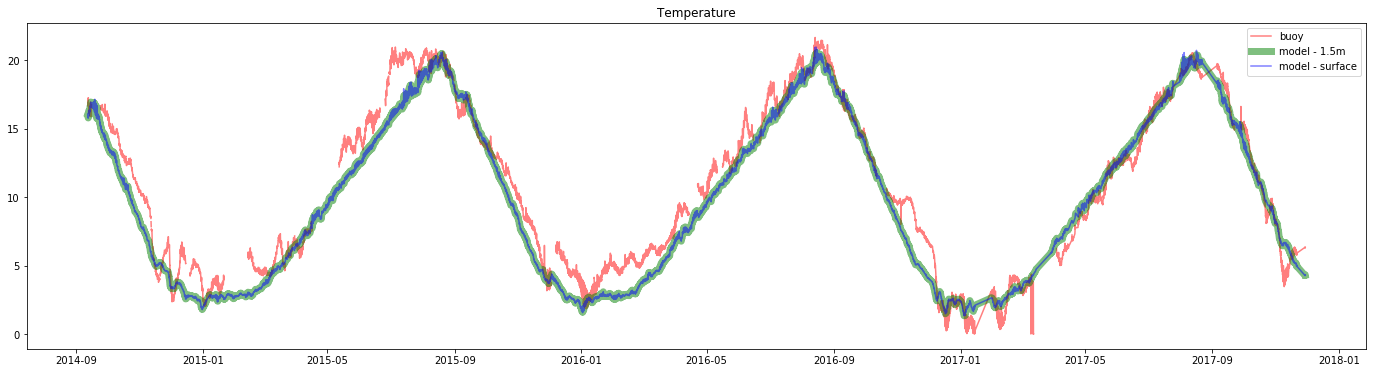

In [20]:
fig, ax = plt.subplots(figsize = (24,6))
ax.plot(py_buoy_times, temps, 'r-', alpha = 0.5, label = 'buoy')
ax.plot(py_buoy_times, t_1_5_model, 'g-', alpha = 0.5, linewidth = 7, label = 'model - 1.5m')
ax.plot(py_buoy_times, t_surface_model, 'b-', alpha = 0.5, label = 'model - surface')
ax.legend()
ax.set_title('Temperature');

In [21]:
temps = np.ma.masked_invalid(temps)
t_1_5_model = np.ma.masked_array(t_1_5_model, mask = temps.mask)
t_surface_model = np.ma.masked_array(t_surface_model, mask = temps.mask)
print(np.ma.count(temps))

23112


In [22]:
from matplotlib.colors import LogNorm

In [23]:
temps = temps.compressed()
t_1_5_model = t_1_5_model.compressed()
t_surface_model = t_surface_model.compressed()

bias =  -0.839681217859
RMSE = 1.49072711918
Willmott = 0.983462238039


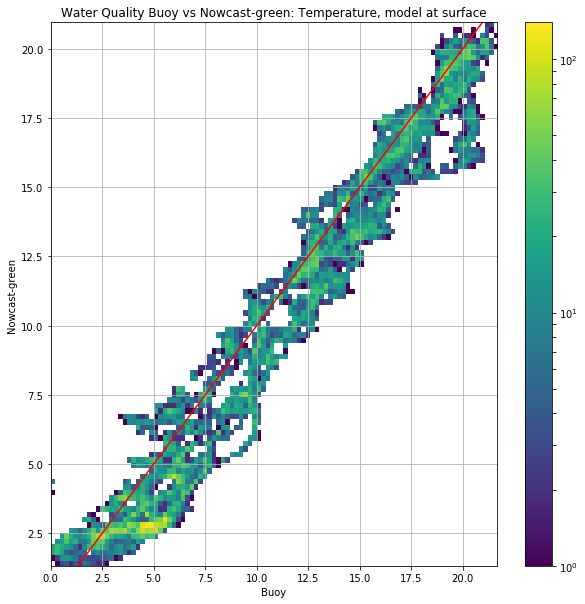

In [24]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(temps, t_surface_model,  
                                bins = 100, norm=LogNorm())
fig.colorbar(im, ax=ax)
ax.plot(np.arange(0,22), 'r-')
ax.grid('on')
ax.set_title('Water Quality Buoy vs Nowcast-green: Temperature, model at surface')
ax.set_xlabel('Buoy')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(temps) + np.mean(t_surface_model)))
print('RMSE = ' + str(np.sqrt(np.sum((t_surface_model - temps)**2) /
                              len(t_surface_model))))
xbar = np.mean(temps)
print('Willmott = ' + str(1-(np.sum((t_surface_model - temps)**2)  / 
                             np.sum((np.abs(t_surface_model - xbar) 
                                     + np.abs(temps - xbar))**2))))

bias =  -0.842048388078
RMSE = 1.49176888156
Willmott = 0.983426478457


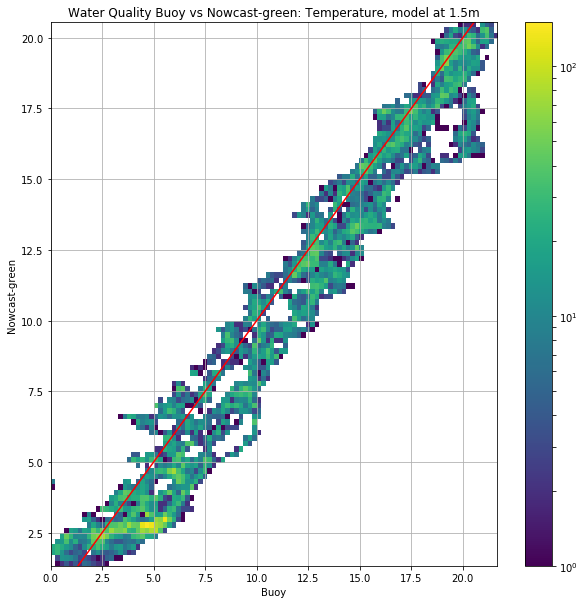

In [25]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(temps, t_1_5_model,  
                                bins = 100, norm=LogNorm())
fig.colorbar(im, ax=ax)
ax.plot(np.arange(0,22), 'r-')
ax.grid('on')
ax.set_title('Water Quality Buoy vs Nowcast-green: Temperature, model at 1.5m')
ax.set_xlabel('Buoy')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(temps) + np.mean(t_1_5_model)))
print('RMSE = ' + str(np.sqrt(np.sum((t_1_5_model - temps)**2) /
                              len(t_1_5_model))))
xbar = np.mean(temps)
print('Willmott = ' + str(1-(np.sum((t_1_5_model - temps)**2)  / 
                             np.sum((np.abs(t_1_5_model - xbar) 
                                     + np.abs(temps - xbar))**2))))

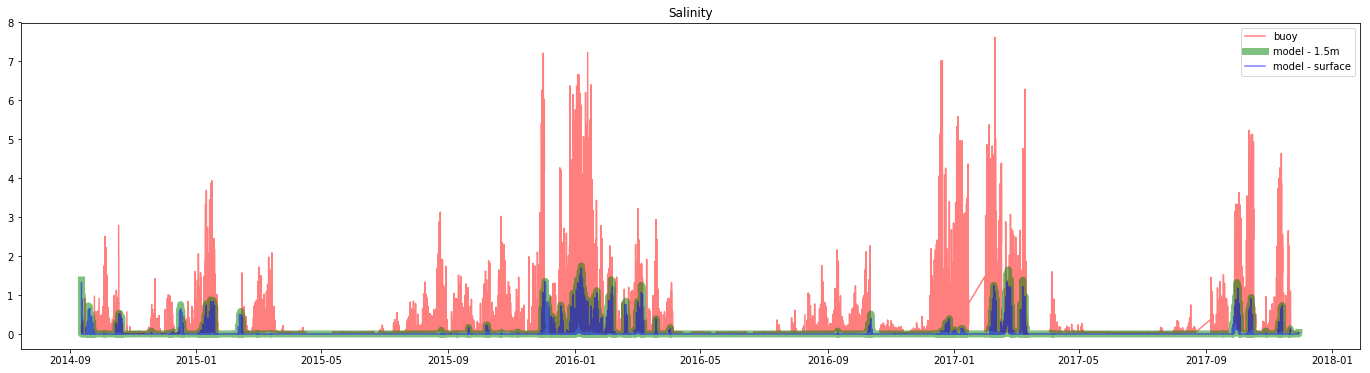

In [26]:
fig, ax = plt.subplots(figsize = (24,6))
ax.plot(py_buoy_times, sals, 'r-', alpha = 0.5, label = 'buoy')
ax.plot(py_buoy_times, sal_1_5_model, 'g-', alpha = 0.5, linewidth = 7, label = 'model - 1.5m')
ax.plot(py_buoy_times, sal_surface_model, 'b-', alpha = 0.5, label = 'model - surface')
ax.legend()
ax.set_title('Salinity');

In [27]:
sals = np.ma.masked_invalid(sals)
sal_1_5_model = np.ma.masked_array(sal_1_5_model, mask = sals.mask)
sal_surface_model = np.ma.masked_array(sal_surface_model, mask = sals.mask)
sals = sals.compressed()
sal_1_5_model = sal_1_5_model.compressed()
sal_surface_model = sal_surface_model.compressed()

In [28]:
len(sals)

23112

bias =  -0.22635754087
RMSE = 0.620525721568
Willmott = 0.349437507799


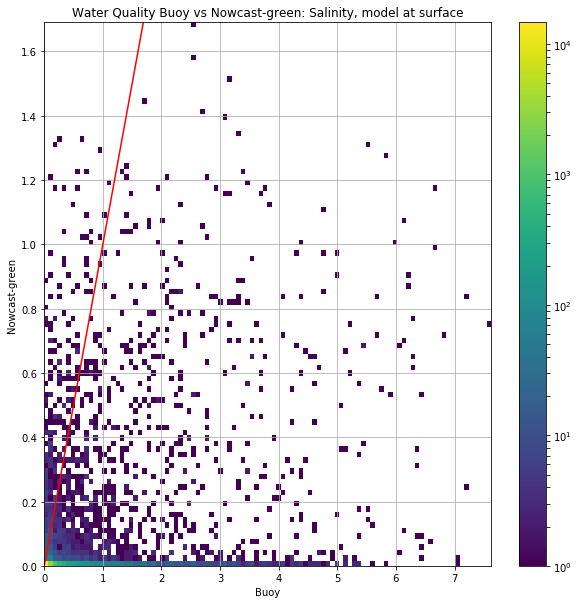

In [29]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(sals, sal_surface_model,  
                                bins = 100, norm=LogNorm())
fig.colorbar(im, ax=ax)
ax.plot(np.arange(0,22), 'r-')
ax.grid('on')
ax.set_title('Water Quality Buoy vs Nowcast-green: Salinity, model at surface')
ax.set_xlabel('Buoy')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(sals) + np.mean(sal_surface_model)))
print('RMSE = ' + str(np.sqrt(np.sum((sal_surface_model - sals)**2) /
                              len(sal_surface_model))))
xbar = np.mean(sals)
print('Willmott = ' + str(1-(np.sum((sal_surface_model - sals)**2)  / 
                             np.sum((np.abs(sal_surface_model - xbar) 
                                     + np.abs(sals - xbar))**2))))

bias =  -0.223250855977
RMSE = 0.617214314718
Willmott = 0.364064080511


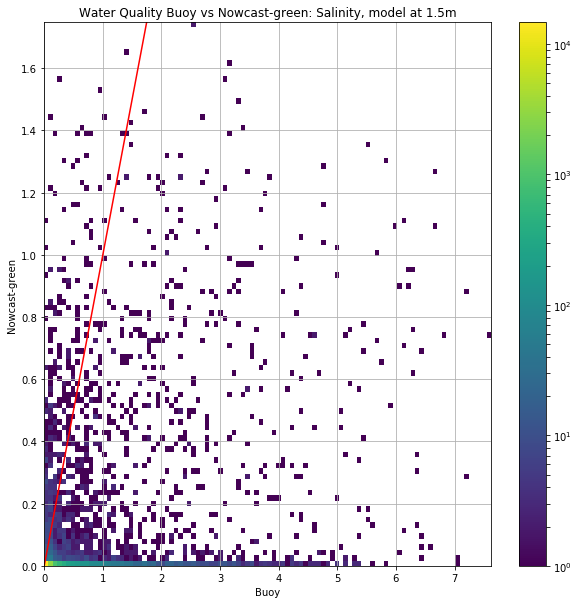

In [30]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(sals, sal_1_5_model,  
                                bins = 100, norm=LogNorm())
fig.colorbar(im, ax=ax)
ax.plot(np.arange(0,22), 'r-')
ax.grid('on')
ax.set_title('Water Quality Buoy vs Nowcast-green: Salinity, model at 1.5m')
ax.set_xlabel('Buoy')
ax.set_ylabel('Nowcast-green');
print('bias =  ' + str(-np.mean(sals) + np.mean(sal_1_5_model)))
print('RMSE = ' + str(np.sqrt(np.sum((sal_1_5_model - sals)**2) /
                              len(sal_1_5_model))))
xbar = np.mean(sals)
print('Willmott = ' + str(1-(np.sum((sal_1_5_model - sals)**2)  / 
                             np.sum((np.abs(sal_1_5_model - xbar) 
                                     + np.abs(sals - xbar))**2))))

In [96]:
import pickle

In [97]:
output = open('sal_surface_model.pkl', 'wb')
pickle.dump(sal_surface_model, output)
output.close()
output = open('sal_1_5_model.pkl', 'wb')
pickle.dump(sal_1_5_model, output)
output.close()
output = open('t_surface_model.pkl', 'wb')
pickle.dump(t_surface_model, output)
output.close()
output = open('t_1_5_model.pkl', 'wb')
pickle.dump(t_1_5_model, output)
output.close()